In [1]:
import numpy as np
import pandas as pd

from dataclasses import dataclass
from typing import Dict, Tuple, Union


#### Assignment 10.2 : Optimal Market-Making

In [2]:
@dataclass
class MarketMaker:
    bid_spread: float = None
    ask_spread: float = None
    trade_pnl: float = 0.0
    inventory: int = 0

    def get_state(self):
        state_dict = {
            "bid_spread": self.bid_spread,
            "ask_spread": self.ask_spread,
            "trade_pnl": self.trade_pnl,
            "inventory": self.inventory,
        }
        return state_dict


@dataclass
class MarketMakerProcess:
    """Base class for modeling dynamics of market maker state."""

    mm: MarketMaker
    T: float = 1.0
    c: int = 140
    S0: float = 100.0
    k: float = 1.5
    dt: float = 0.005
    gamma: float = 0.1
    sigma: float = 2

    S: float = None

    def get_mm_state(self):
        return self.mm.get_state()

    def reset_mm(self):
        self.mm = MarketMaker()

    def get_dynamic_spread(self, t: float) -> Tuple[float, float]:
        mm = self.mm
        offset = (1 / self.gamma) * np.log(1 + self.gamma / self.k)
        delta_b = (
            (2 * mm.inventory + 1) * self.gamma * self.sigma ** 2 * (self.T - t) / 2
        ) + offset
        delta_a = (
            (1 - 2 * mm.inventory) * self.gamma * self.sigma ** 2 * (self.T - t) / 2
        ) + offset
        return delta_b, delta_a

    def simulate_path(self, dynamic_spread: bool = True):
        self.S = self.S0
        for t in range(self.T / self.dt):
            pass

    def dyn_spread_simulate_path(self) -> MarketMaker:
        metric_dict = {
            "t": [],
            "inventory": [],
            "S": [],
            "delta_a": [],
            "delta_b": [],
            "pnl": [],
            "w": [],
        }
        self.S = self.S0
        curr_t = 0

        for t in range(np.ceil(self.T / self.dt).astype(int)):
            delta_b, delta_a = self.get_dynamic_spread(t=curr_t)
            self.hit_draw(delta_b)
            self.lift_draw(delta_a)
            self.evolve_midpoint()

            metric_dict["t"].append(t)
            metric_dict["inventory"].append(self.mm.inventory)
            metric_dict["delta_a"].append(delta_a)
            metric_dict["delta_b"].append(delta_b)
            metric_dict["S"].append(self.S)
            metric_dict["pnl"].append(self.mm.trade_pnl)
            metric_dict["w"].append(self.S * self.mm.inventory + self.mm.trade_pnl)
            curr_t += self.dt
        return self.mm, metric_dict

    def const_spread_simulate_path(
        self, delta_c
    ) -> Tuple[MarketMaker, Dict[str, Union[int, float]]]:
        metric_dict = {
            "t": [],
            "inventory": [],
            "S": [],
            "delta_a": [],
            "delta_b": [],
            "pnl": [],
            "w": [],
        }
        self.S = self.S0
        curr_t = 0

        for t in range(np.ceil(self.T / self.dt).astype(int)):
            self.hit_draw(delta_c)
            self.lift_draw(delta_c)
            self.evolve_midpoint()

            metric_dict["t"].append(t)
            metric_dict["inventory"].append(self.mm.inventory)
            metric_dict["delta_a"].append(delta_c)
            metric_dict["delta_b"].append(delta_c)
            metric_dict["S"].append(self.S)
            metric_dict["pnl"].append(self.mm.trade_pnl)
            metric_dict["w"].append(self.S * self.mm.inventory + self.mm.trade_pnl)
            curr_t += self.dt
        return self.mm, metric_dict

    def simulate_dyn_spread_traces(self, n_sims: int):
        W = []
        avg_delta_a = []
        avg_delta_b = []
        for _ in range(n_sims):
            metric_dict = self.dyn_spread_simulate_path()[1]
            W.append(-np.exp(-self.gamma * metric_dict["w"][-1]))
            avg_delta_a.append(np.mean(metric_dict["delta_a"]))
            avg_delta_b.append(np.mean(metric_dict["delta_b"]))
            self.reset_mm()
        return W, avg_delta_a, avg_delta_b

    def simulate_const_spread_traces(self, delta_c: float, n_sims: int):
        W = []
        for _ in range(n_sims):
            metric_dict = self.const_spread_simulate_path(delta_c=delta_c)[1]
            W.append(-np.exp(-self.gamma * metric_dict["w"][-1]))
            self.reset_mm()
        return W

    def hit_draw(self, delta_b):
        """Randomly generate a hit event for the market maker."""
        hit_spinner = np.random.random()
        if hit_spinner < self.c * np.exp(-self.k * delta_b) * self.dt:
            self.mm.inventory += 1
            self.mm.trade_pnl -= self.S - delta_b

    def lift_draw(self, delta_a):
        """Randomly generate a lift event for the market maker."""
        lift_spinner = np.random.random()
        if lift_spinner < self.c * np.exp(-self.k * delta_a) * self.dt:
            self.mm.inventory -= 1
            self.mm.trade_pnl += self.S + delta_a

    def evolve_midpoint(self):
        midpoint_spinner = np.random.random()
        dS = self.sigma * np.sqrt(self.dt)
        if midpoint_spinner > 0.5:
            self.S += dS
        else:
            self.S -= dS


expected utility under dynamic model : -0.0018535524986145202
expected utility under naive / constant model : -0.004639106694546526


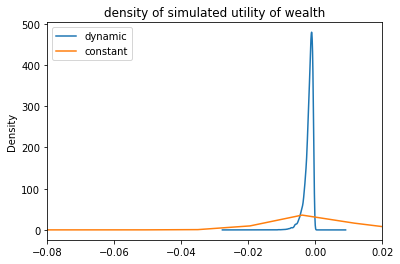

In [3]:
n_sims = 20_000

mm = MarketMaker()
mmp = MarketMakerProcess(mm=mm)

w_dyn, delta_a_avgs, delta_b_avgs = mmp.simulate_dyn_spread_traces(n_sims=n_sims)

delta_a_avg = np.mean(delta_a_avgs)
delta_b_avg = np.mean(delta_b_avgs)

delta_c = np.mean([delta_a_avg, delta_b_avg])

w_const = mmp.simulate_const_spread_traces(delta_c=delta_c, n_sims=n_sims)


df = pd.DataFrame([w_dyn, w_const], index=["dynamic", "constant"]).T
df.plot(
    kind="density", xlim=(-0.08, 0.02), title="density of simulated utility of wealth"
)

print(f"expected utility under dynamic model : {np.mean(df['dynamic'])}")
print(f"expected utility under naive / constant model : {np.mean(df['constant'])}")


In [4]:
mmp.reset_mm()
dyn_metric_df = pd.DataFrame(mmp.dyn_spread_simulate_path()[1])
mmp.reset_mm()
const_metric_df = pd.DataFrame(mmp.const_spread_simulate_path(delta_c=delta_c)[1])

merged_df = dyn_metric_df.merge(
    const_metric_df, how="outer", suffixes=["_dyn", "_const"], left_on="t", right_on="t"
).set_index("t")

merged_df

,inventory_dyn,S_dyn,delta_a_dyn,delta_b_dyn,pnl_dyn,w_dyn,inventory_const,S_const,delta_a_const,delta_b_const,pnl_const,w_const
t,,,,,,,,,,,,
0,0,99.858579,0.845385,0.845385,0.000000,0.000000,0,100.141421,0.745885,0.745885,0.000000,0.000000
1,0,100.000000,0.844385,0.844385,0.000000,0.000000,0,100.000000,0.745885,0.745885,1.491770,1.491770
2,-1,99.858579,0.843385,0.843385,100.843385,0.984807,0,100.141421,0.745885,0.745885,1.491770,1.491770
3,-1,99.717157,1.236385,0.448385,100.843385,1.126228,0,100.000000,0.745885,0.745885,1.491770,1.491770
4,-1,99.575736,1.233385,0.449385,100.843385,1.267649,0,100.141421,0.745885,0.745885,1.491770,1.491770
...,...,...,...,...,...,...,...,...,...,...,...,...
195,6,96.888730,0.590385,0.710385,-509.027127,72.305254,8,98.302944,0.745885,0.745885,-718.135125,68.288425
196,6,96.747309,0.601385,0.697385,-509.027127,71.456726,8,98.444365,0.745885,0.745885,-718.135125,69.419795
197,6,96.888730,0.612385,0.684385,-507.730357,73.602024,7,98.302944,0.745885,0.745885,-618.944875,69.175731


In [5]:
import matplotlib.pyplot as plt


def metric_subplots(df: pd.DataFrame, title: str) -> None:
    figs, axs = plt.subplots(1, 3, figsize=(30, 10))
    figs.suptitle(f"{title} Implementation")

    bid_price_series = df["S"] - df["delta_b"]
    ask_price_series = df["S"] + df["delta_a"]

    df["S"].plot(label="OB-mid", ax=axs[0])
    ask_price_series.plot(label="ask price", ax=axs[0])
    bid_price_series.plot(label="bid price series", ax=axs[0])
    axs[0].legend()

    df["pnl"].plot(label="trade PnL", ax=axs[1])
    axs[1].legend()

    df["inventory"].plot(label="inventory", ax=axs[2])
    axs[2].legend()


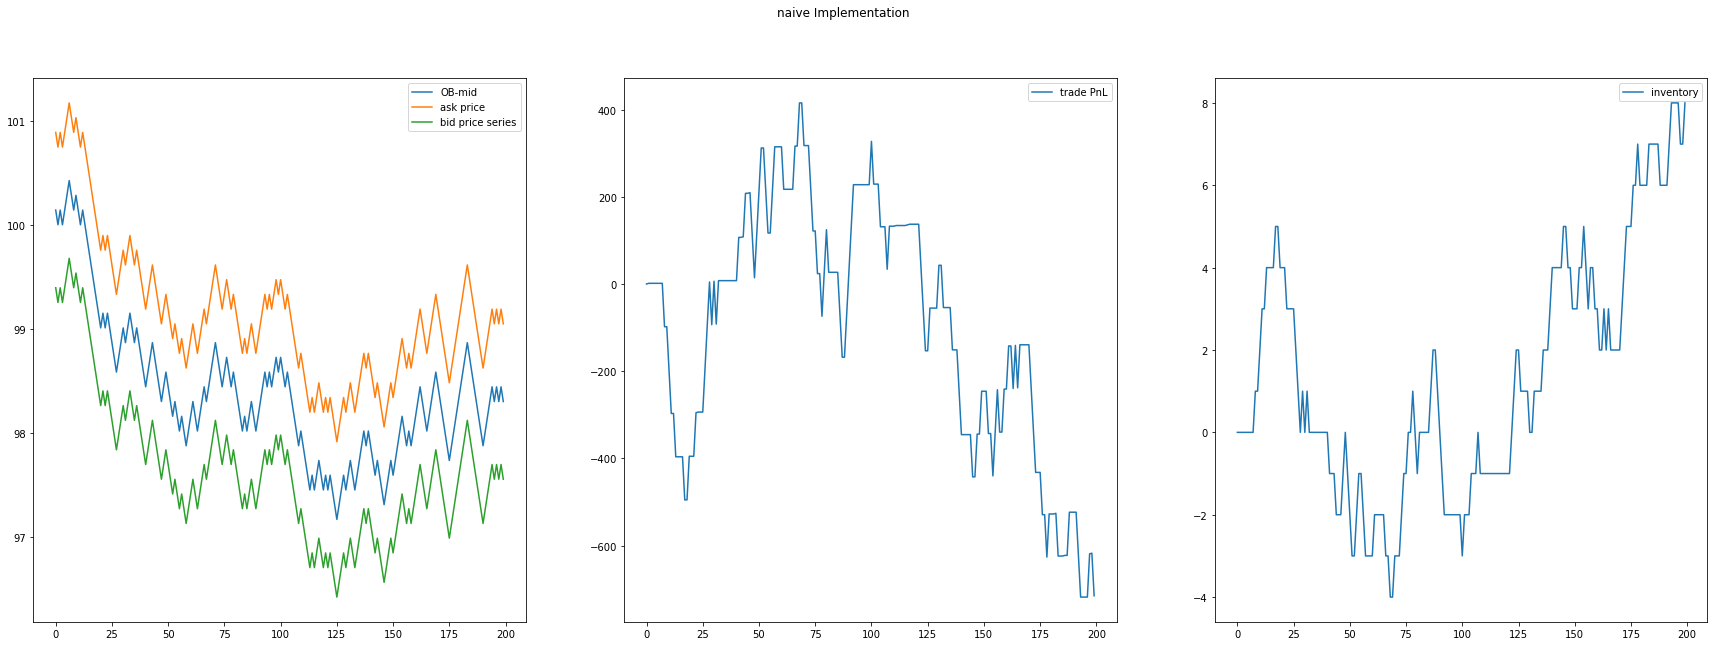

In [6]:
metric_subplots(const_metric_df, "naive")

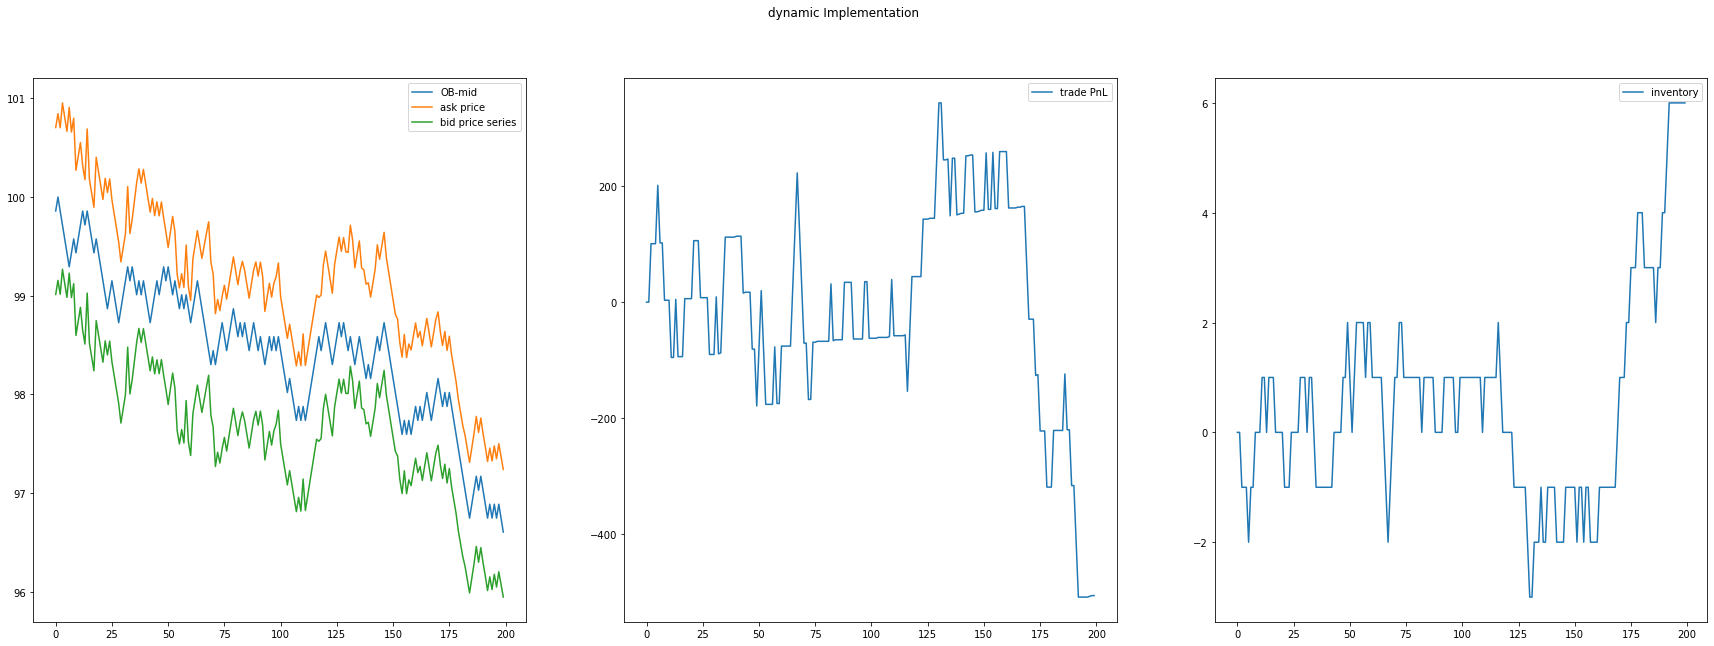

In [7]:
metric_subplots(dyn_metric_df, "dynamic")